In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# from functions import *



In [2]:
haplotype_df = pd.read_parquet('/home/jupyter-yusuf/Consensus/output/3_haplotypes.parquet')


In [10]:
def barplot_frequency(data, x_col, y_col, xlabel, ylabel, title, figsize=(30, 15), fontsize=15, label_fontsize=30, title_fontsize=None, x_ticks_rotation=True, ylim=None, legend=None, color='#ADD8E6', ci=None, colored_xticks=False, color_col=None, hue=None, palette='Set2', grid=False):
    plt.figure(figsize=figsize)
    chart = sns.barplot(x=x_col, y=y_col, data=data, color=color, errorbar=None, hue=hue, palette=palette, edgecolor='black')

    for p in chart.patches:
        chart.annotate("{:,.2f}".format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=fontsize)

    plt.xlabel(xlabel, fontsize=label_fontsize, labelpad=20)
    plt.ylabel(ylabel, fontsize=label_fontsize)
    if grid:
        plt.grid(alpha=0.2)

    if title_fontsize is not None:
        plt.title(title, fontsize=title_fontsize, loc='center', pad=20)
    else:
        plt.title(title, fontsize=30, loc='center', pad=20)

    if x_ticks_rotation:
        plt.xticks(rotation=45, fontsize=15)
        plt.yticks(fontsize=15)
    else:
        plt.xticks(fontsize=15, weight='semibold')
        plt.yticks(fontsize=13)

    if ylim is not None:
        plt.ylim(0, ylim)

    if colored_xticks and color_col:
        unique_values = data[color_col].unique()
        color_palette = ['green', 'blue', 'tomato', 'yellow', 'brown', 'black'] #sns.color_palette("Paired", len(unique_values))
        color_map = dict(zip(unique_values, color_palette))

        for i, tick in enumerate(chart.get_xticklabels()):
            tick.set_color(color_map[data[color_col].iloc[i]])

    if legend is not None and hue:
        hue_legend = plt.legend(title=legend, fontsize=15, fancybox=True, framealpha=1, shadow=True, borderpad=1, loc='best', bbox_to_anchor=(0.82, 1))

    if legend is not None and hue and color_col is None:
        hue_legend = plt.legend(title=None, fontsize=20, fancybox=True, framealpha=1, shadow=True, borderpad=1, loc='best')
    if legend is not None and colored_xticks and color_col:
        patch_list = []
        for key, value in color_map.items():
            patch_list.append(mpatches.Patch(color=value, label=key))
        xtick_legend = plt.legend(handles=patch_list, title="Function", loc=1, fontsize=15, fancybox=True, framealpha=1, shadow=True, borderpad=1)
        plt.gca().add_artist(hue_legend)
        plt.show()
        
    plt.tight_layout()
    plt.show()




# 1. Haplotype Frequency Distribution 

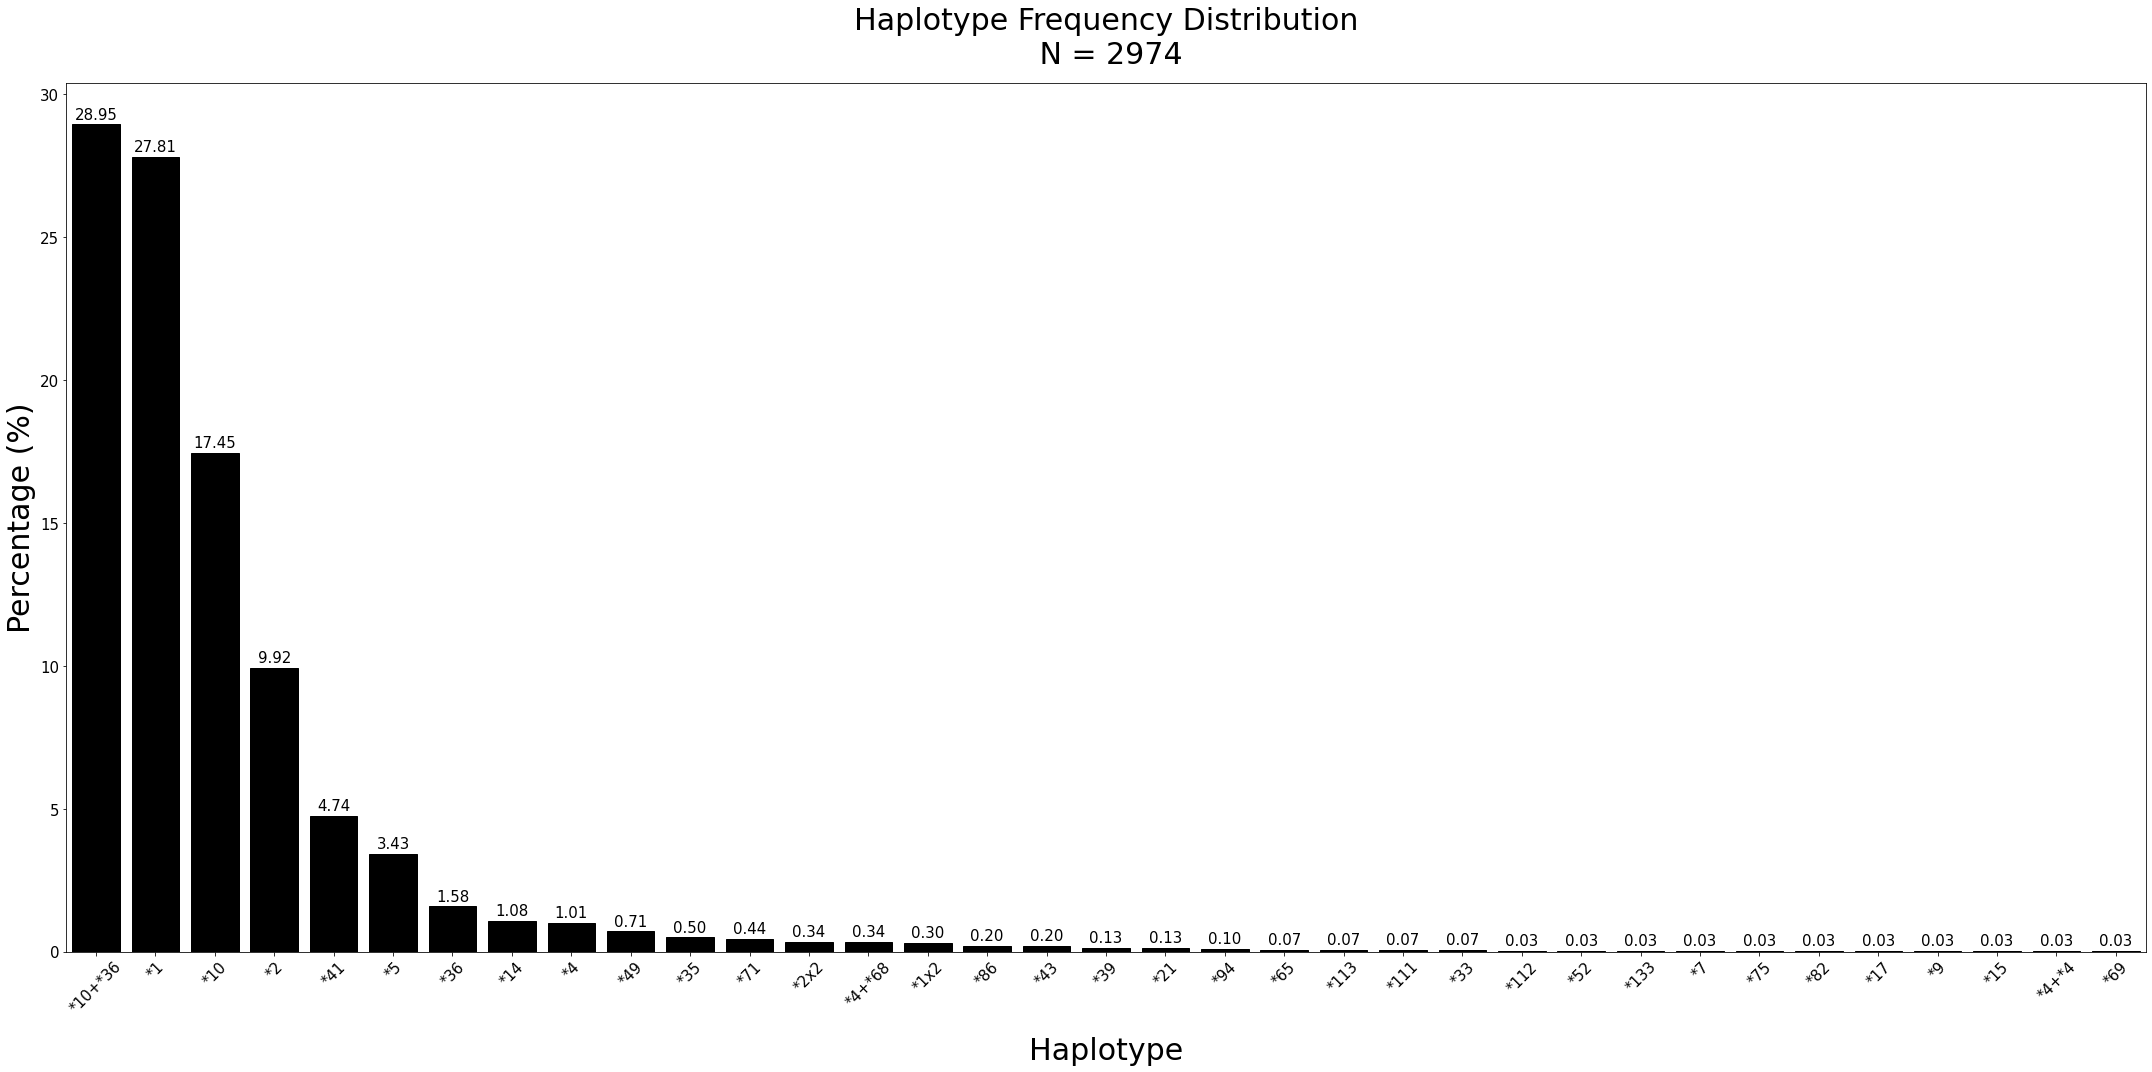

In [13]:
# Haplotype Frequency Distribution
barplot_frequency(haplotype_df, x_col='haplotype', y_col='AF', xlabel='Haplotype', ylabel='Percentage (%)', title=f"Haplotype Frequency Distribution\n N = {haplotype_df['AC'].sum()}", color='black', palette=None)


# 2. Haplotype Frequency Distribution Amongst Genetic Ancestry

In [14]:
data = pd.melt(haplotype_df, id_vars=['haplotype', 'activity_value', 'function', 'AF'], value_vars=['AF_GA_C', 'AF_GA_I', 'AF_GA_M'], var_name='genetic_ancestry', value_name='percentage')
data = data.replace({'AF_GA_C': 'Chinese', 'AF_GA_I': 'Indian', 'AF_GA_M': 'Malay'})
top_10_haplotypes = haplotype_df.sort_values(by='AF', ascending=False).head(10)['haplotype'].tolist()

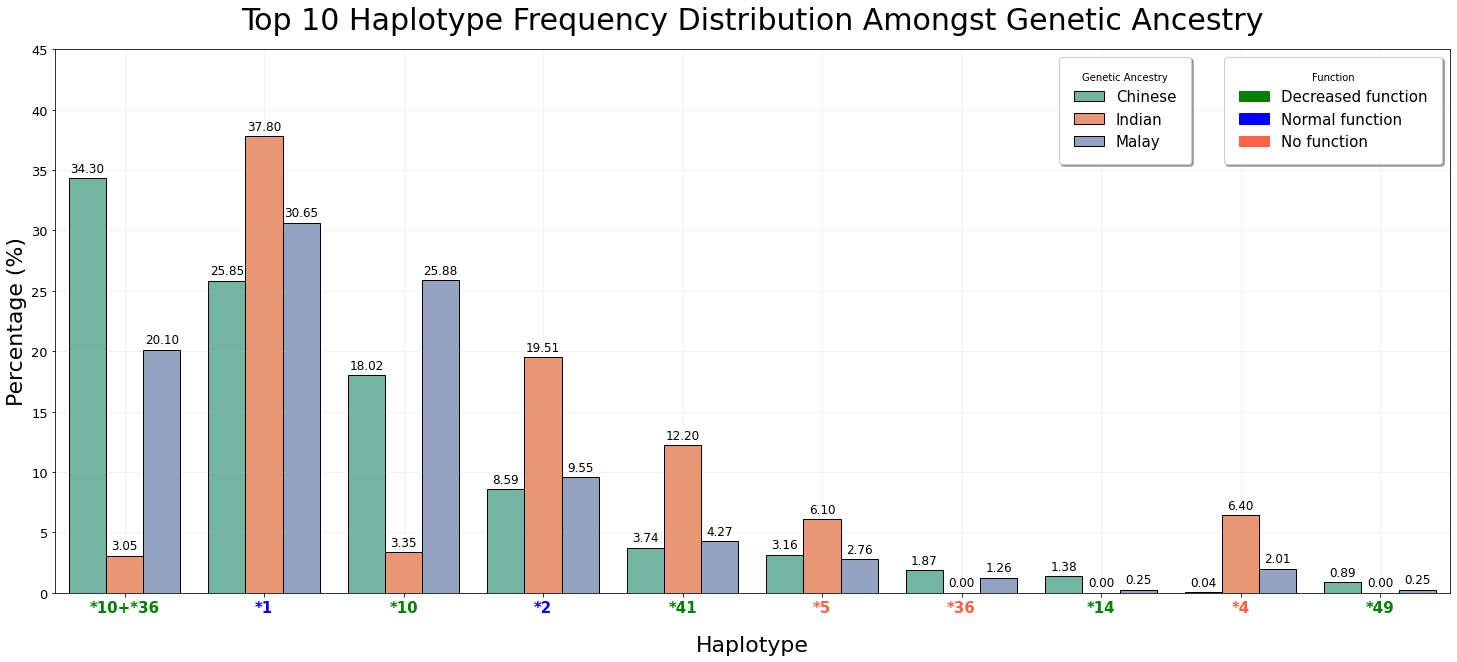

<Figure size 432x288 with 0 Axes>

In [15]:
barplot_frequency(data[data['haplotype'].isin(top_10_haplotypes)], 
                  x_col='haplotype', y_col='percentage', 
                  xlabel='Haplotype', ylabel='Percentage (%)', 
                  title='Top 10 Haplotype Frequency Distribution Amongst Genetic Ancestry', 
                  figsize=(25, 10), fontsize=12, label_fontsize=22,
                  x_ticks_rotation=False, ylim=45, legend='Genetic Ancestry', hue='genetic_ancestry', palette='Set2',
                  colored_xticks=True, color_col="function", grid = True)


## Manuscript figure

In [24]:
def calculate_sample(ga):
	if ga == 'Chinese':
		return f'Chinese (N={int(haplotype_df["AC_C"].sum())})'
	elif ga == 'Indian':
		return f'Indian (N={int(haplotype_df["AC_I"].sum())})'
	else:
		return f'Malay (N={int(haplotype_df["AC_M"].sum())})'

In [45]:
data_modified = data.copy()
data_modified['function_status'] = data_modified['function'].str.extract(r'(Normal|Decreased|No|Increased|Uncertain)')
data_modified['haplotype'] = data_modified['haplotype'] + " (" + data_modified['function_status'] + ")"
data_modified['genetic_ancestry'] = data_modified['genetic_ancestry'].apply(calculate_sample)

haplotype_df_modified = haplotype_df.copy()
haplotype_df_modified['function_status'] = haplotype_df_modified['function'].str.extract(r'(Normal|Decreased|No|Increased|Uncertain)')
haplotype_df_modified['haplotype'] = haplotype_df_modified['haplotype'] + " (" + haplotype_df_modified['function_status'] + ")"


top10_modified = haplotype_df_modified.sort_values(by='AF', ascending=False).head(10)['haplotype'].tolist()
top10_modified

In [46]:
data_modified['haplotype'] = np.where(data_modified['haplotype'].isin(top10_modified), data_modified['haplotype'], 'Others')

In [47]:
data_modified = data_modified.groupby(['haplotype', 'genetic_ancestry']).sum().reset_index()

/tmp/ipykernel_582006/474350453.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_modified = data_modified.groupby(['haplotype', 'genetic_ancestry']).sum().reset_index()


In [55]:
ancestry_color_map = {
    f'Chinese (N={int(haplotype_df["AC_C"].sum())})': '#8f001D',  
    f'Malay (N={int(haplotype_df["AC_M"].sum())})': '#107b01',    
    f'Indian (N={int(haplotype_df["AC_I"].sum())})': '#7e00ff'    
}

In [56]:
order_list = ['*36+*10 (Decreased)',
 '*1 (Normal)',
 '*10 (Decreased)',
 '*2 (Normal)',
 '*41 (Decreased)',
 '*5 (No)',
 '*36 (No)',
 '*14 (Decreased)',
 '*4 (No)',
 '*49 (Decreased)',
 'Others']

order_list_ga = [f'Chinese (N={int(haplotype_df["AC_C"].sum())})', f'Malay (N={int(haplotype_df["AC_M"].sum())})', f'Indian (N={int(haplotype_df["AC_I"].sum())})']


In [58]:
data_modified['haplotype'] = data_modified['haplotype'].replace("*10+*36 (Decreased)", "*36+*10 (Decreased)")
data_modified['haplotype'] = pd.Categorical(data_modified['haplotype'], categories=order_list, ordered=True)
data_modified['genetic_ancestry'] = pd.Categorical(data_modified['genetic_ancestry'], categories=order_list_ga, ordered=True)


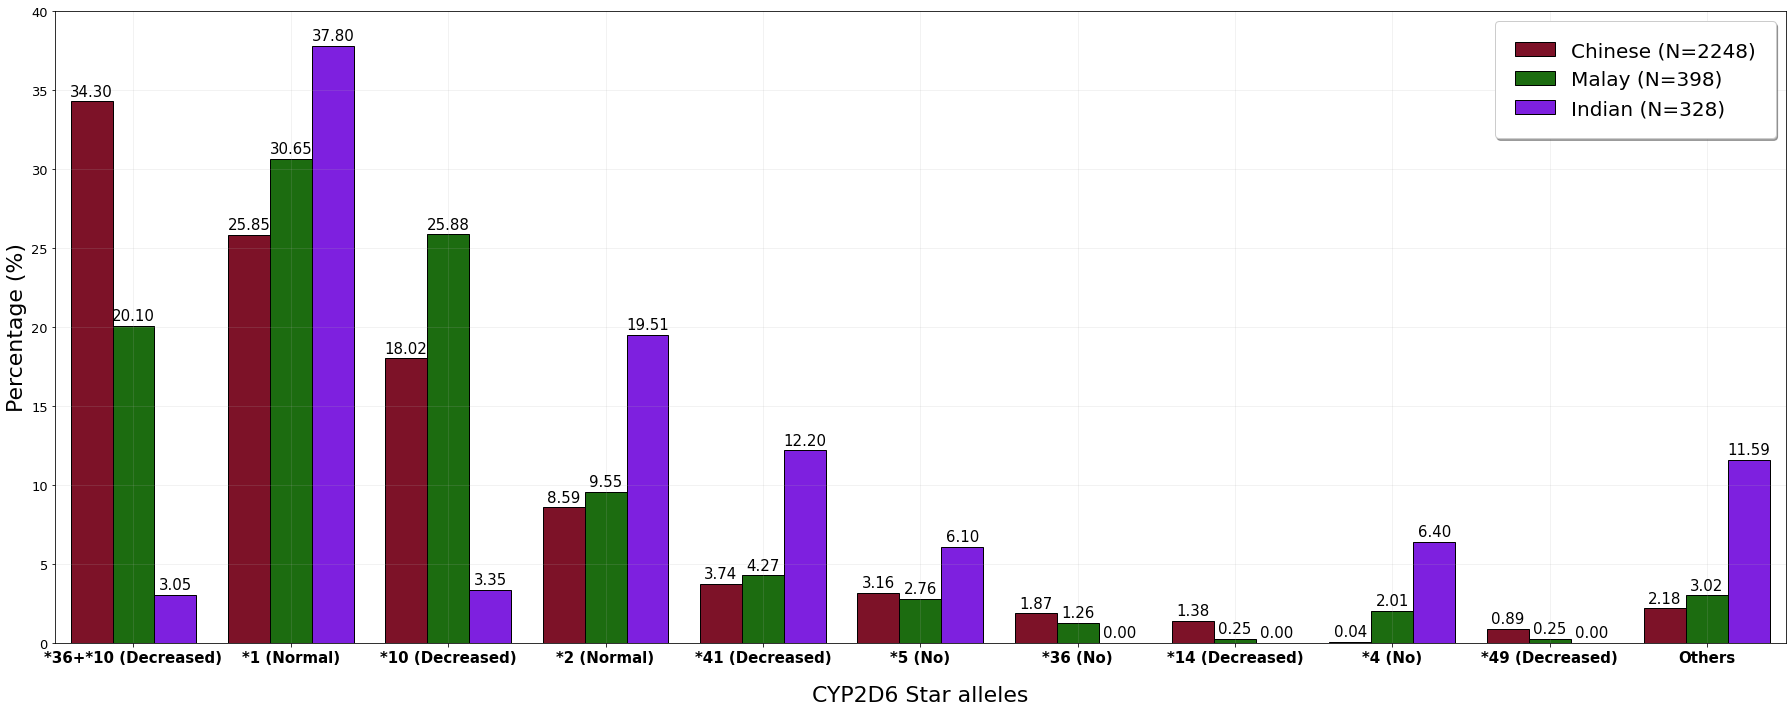

In [60]:
barplot_frequency(data_modified,
                  x_col='haplotype', y_col='percentage', 
                  xlabel='CYP2D6 Star alleles', ylabel='Percentage (%)', 
                  title=None, 
                  figsize=(25, 10), fontsize=15, label_fontsize=22,
                  x_ticks_rotation=False, ylim=40, hue='genetic_ancestry', palette=ancestry_color_map, legend="Genetic Ancestry",
                  colored_xticks=False, grid = True)
